In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings

In [167]:
warnings.filterwarnings('ignore')

In [168]:
file_path = '../../../volza/magnesium/magnesium.csv'
data = pd.read_csv(file_path)

# Only keep YY-MM-DD
data['Date'] = pd.to_datetime(data['Date'].str.split(' ').str[0])
data.sort_values('Date', inplace=True)

# Set 'Date' as the index
data.set_index('Date', inplace=True)

In [169]:
# Filter for specific countries
countries_export = ['China', 'Netherlands', 'Germany','Israel', 'Turkey']
# countries_export = ['China']
# countries_import = ['Netherlands']

filtered_data = data[(data['Country of Origin'].isin(countries_export))]


# filtered_data = data[(data['Country of Origin'].isin(countries_export)) & 
#                      (data['Country of Destination'].isin(countries_import))]

filtered_data[['Country of Origin', 'Country of Destination', 'Value']].head(10)

,Country of Origin,Country of Destination,Value
Date,,,
2020-01-01,Netherlands,Hungary,490969.66
2020-01-01,China,Netherlands,10015044.94
2020-01-01,China,Vietnam,0.00
2020-01-01,China,Hungary,215385.39
2020-01-01,China,Vietnam,0.00
2020-01-01,Netherlands,Hungary,56611.24
2020-01-01,China,Slovenia,2443624.72
2020-01-01,China,Italy,573502.25
2020-01-01,China,Vietnam,0.00


In [170]:
grouped_data = filtered_data.groupby('Country of Origin')

In [171]:
# Initialize a dictionary to store the autoregression models and predictions for each country
ar_models = {}
predictions = {}

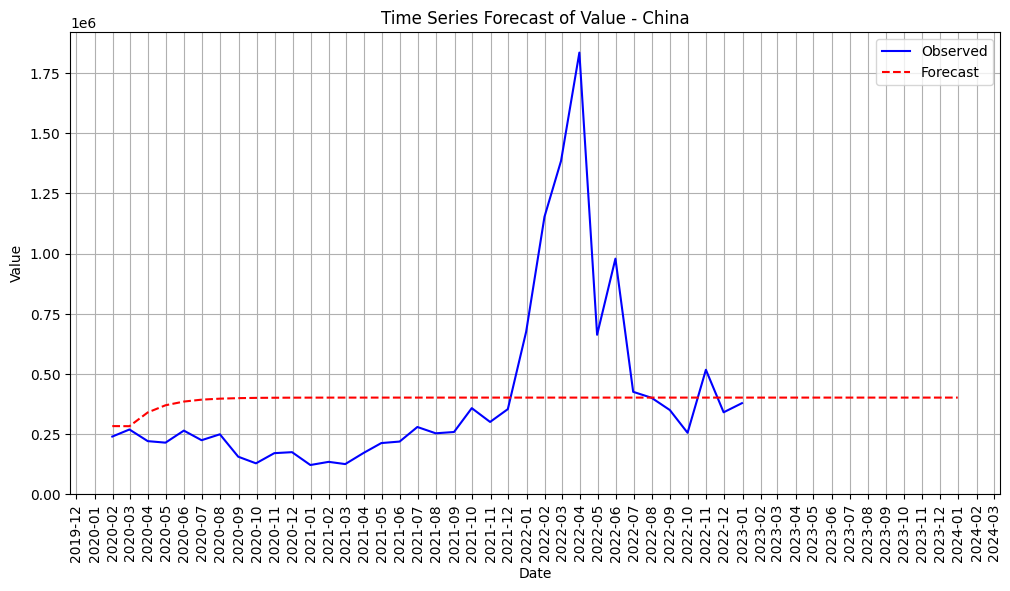

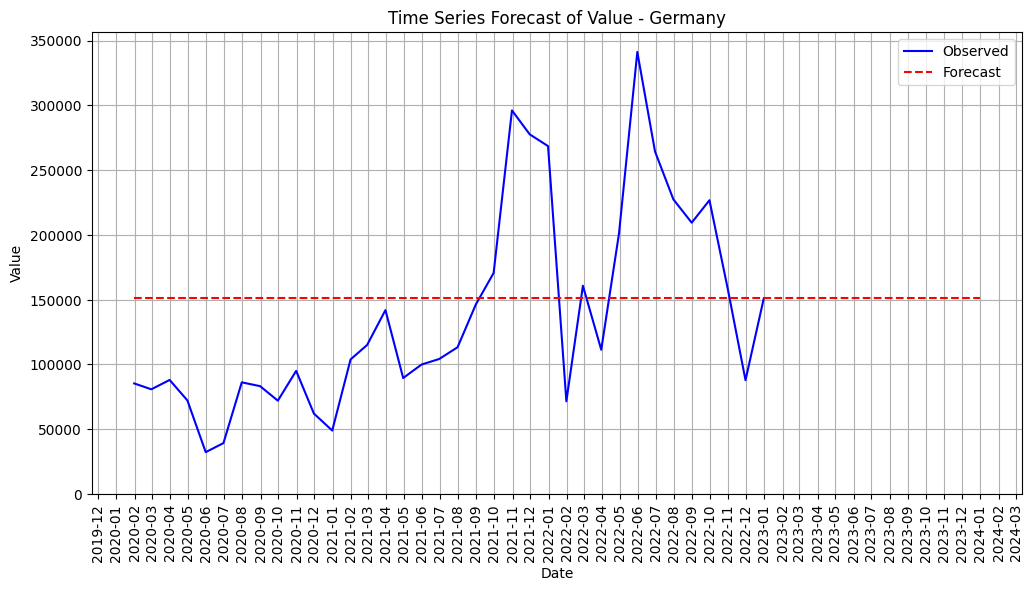

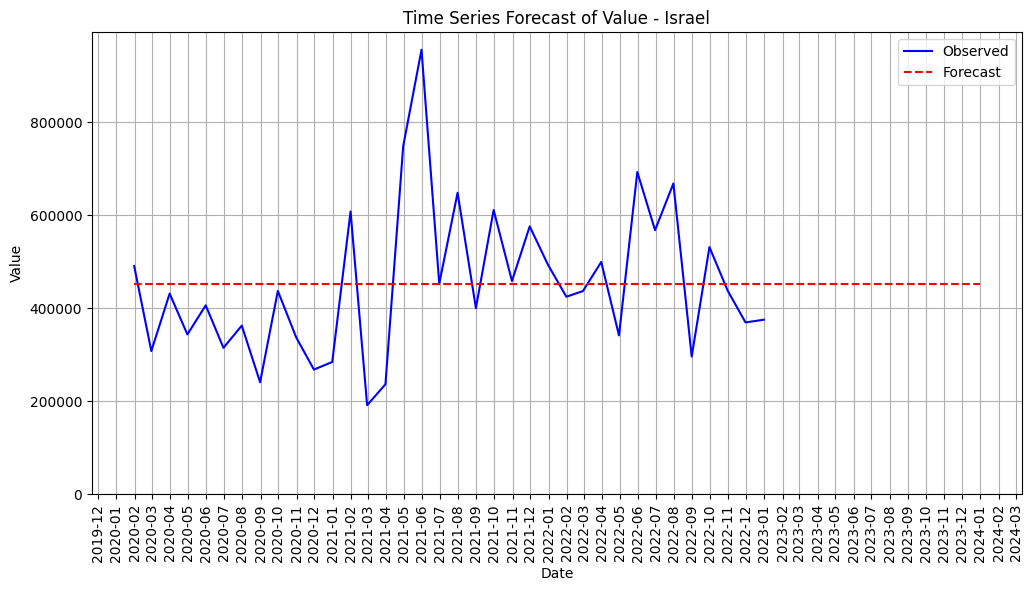

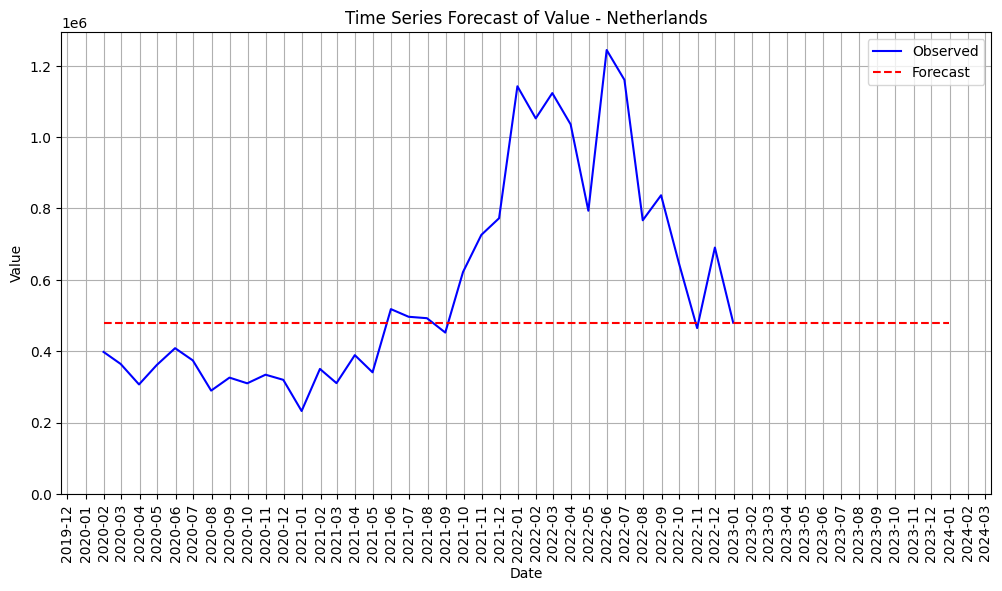

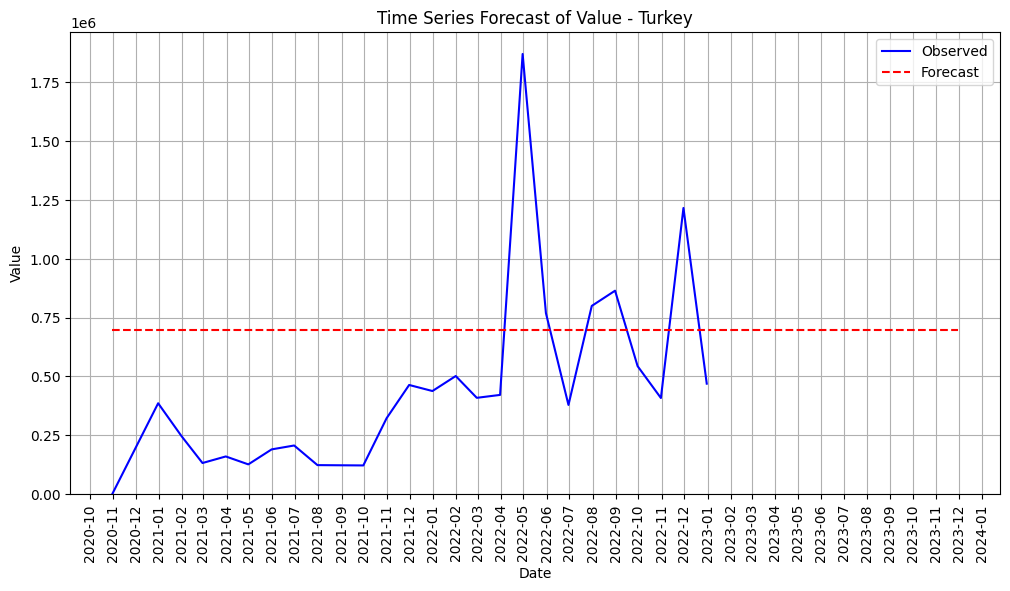

In [172]:
for country, group in grouped_data:
    # Resample the data monthly and take the mean of the 'Value' column
    monthly_data = group['Value'].resample('M').mean()
    monthly_data.dropna(inplace=True)

    # Automatically determine the ARIMA parameters
    auto_model = auto_arima(monthly_data, seasonal=False, stepwise=True, trace=False)
    p, d, q = auto_model.order

    # Fit the ARIMA model
    model = ARIMA(monthly_data, order=(p, d, q))
    arima_model = model.fit()

    # Forecasting the observed months + the next 12 months
    total_forecast_length = len(monthly_data) + 12
    forecast = arima_model.get_forecast(steps=total_forecast_length)
    prediction = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # Generate dates for the entire forecast (both observed and future)
    forecast_dates = pd.date_range(start=monthly_data.index[0], 
                                   periods=total_forecast_length, 
                                   freq='M')

    # Plotting the observed data
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_data.index, monthly_data, label='Observed', color='blue')

    # Plotting the predictions (both in-sample and out-of-sample)
    plt.plot(forecast_dates, prediction, label='Forecast', linestyle='--', color='red')
    # plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=0.1)

    # Setting the chart title and labels
    plt.title(f'Time Series Forecast of Value - {country}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.gca().set_ylim(ymin=0)
    
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=90)

    plt.legend()
    plt.grid(True)
    plt.show()
